In [89]:
# Import pandas and get version
import pandas as pd
pd.__version__

'1.3.5'

In [90]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

# Set dataset path
root = '/gdrive/MyDrive/DataScience_Datasets/'

Mounted at /gdrive


In [91]:
# Check to make sure everything is fine
! ls '/gdrive/MyDrive/DataScience_Datasets'

AB_NYC_2019.csv  new-york-city-airbnb-open-data.zip


In [92]:
# Read dataset from CSV and create Pandas dataframe 
raw_df = pd.read_csv(root + "AB_NYC_2019.csv")

In [93]:
raw_df.head() # Preview our dataset

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [94]:
raw_df.shape

(48895, 16)

Here, we can drop columns that aren't important to us for simplicity's sake. 


*   As general neighbourhood is what matters to us, we can safely drop the `latitude` and `longitude` columns.
*   `host_name` and `name` aren't important to us, as we'll be using `id` and `host_id` to identify the listings/hosts.
*    `last_review` isn't particularly important to us either, so this column will be dropped as well.

In [95]:
df = raw_df.drop(columns=["latitude", "longitude", "host_name", "name", "last_review"], axis=1)

# Our dataframe now looks like this:
df.head()

,id,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365
1,2595,2845,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
2,3647,4632,Manhattan,Harlem,Private room,150,3,0,NaN,1,365
3,3831,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194
4,5022,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0


Before moving onto the next stage, let's check and see if there are any duplicates for us to remove:

In [96]:
df.duplicated().sum()

0

None! Onto the next stage.

# **1. Finding null data points and outliers**

Null data points will be handled using the `dropna()` function. 
This function has two required parameters:


1.   **`axis`**: Determines if rows or columns that contain missing values should be removed. We will be dropping on a row basis, that means for the `axis` argument we will pass `0` or *`'index'`* to indicate that rows with missing values should be dropped.


2.   **`how`**: Determines if the row that is to be removed should have at least one NA or all NA. For now, we will pass *`'any'`* for this parameter, so that if one value is NA, the row will be dropped. After doing this, we will check the shape of the dataframe to make sure it's not too small.

While both of the parameters above are required, the default values for each is *0/'index'* and *'any'* respectively, so we do not need to pass any parameters to our function.


In [97]:
# First, let's see how many NA data points we have per column
df.isna().sum()

id                                    0
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Based on the nature of the `reviews_per_month` column, it is safe to assume that NA values in this column could safely be replaced with 0. We can do this using the `fillna()` method.

In [98]:
# Replace NA values in reviews_per_month column with 0
df['reviews_per_month'] = raw_df['reviews_per_month'].fillna(0)

Now, let's check our NA data points once more. As you'll see below, there's a very large difference.

In [99]:
df.isna().sum() # Drastic difference compared to before

id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Now for the next step: **Outlier removal**.

Our goal is to detect and remove any rows with prices that differ significantly from other prices. 
One option would be to run our outlier detection algorithm over *the entire price column*, but we wouldn't be factoring in other contributing factors such as neighborhood that play a massive role in a house's price. For simplicity's sake and to avoid losing potentially valuable information, we'll be using `neighborhood_group` instead of `neighborhood`s here.

To better illustrate this point, let's visualize the mean price per neighborhood group:

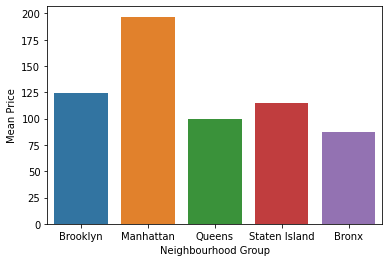

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

neighbourhood_group = "neighbourhood_group"
neighbourhood_groups = df[neighbourhood_group].unique()  # Get all unique neighbourhood groups
mean_prices = []

# Get list of mean price per neighbourhood group
for neighbourhood in neighbourhood_groups:
  mean_prices.append(df.loc[df[neighbourhood_group] == neighbourhood]["price"].mean()) 

# Create barplot
ax = sns.barplot(x=neighbourhood_groups, y=mean_prices)
ax.set(xlabel="Neighbourhood Group", ylabel="Mean Price")
plt.show()

As seen in the barplot above, Bronx has the lowest mean price and Manhattan has the highest. We can visualize the individual prices using a scatter plot:

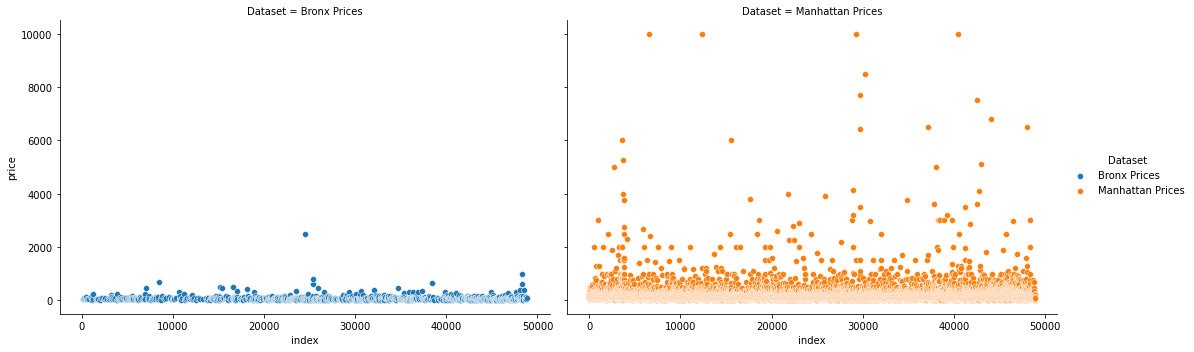

In [101]:
bronx_prices = df.loc[df[neighbourhood_group] == "Bronx"]["price"].to_frame()
manhattan_prices = df.loc[df[neighbourhood_group] == "Manhattan"]['price'].to_frame()

concat_prices = pd.concat([bronx_prices.assign(Dataset='Bronx Prices'), manhattan_prices.assign(Dataset='Manhattan Prices')]).reset_index()

grid = sns.FacetGrid(concat_prices, col="Dataset", hue="Dataset", height=5.0, aspect=1.5)
grid.map(sns.scatterplot, "index", "price")
grid.add_legend()

plt.show()

As shown in the figure above, there's a *lot* more variation in prices for listings in the Manhattan neighbourhood group. Similarly, if we do outlier filtering on *all* prices across *all* neighbourhood groups, we risk missing outliers in specific neighbourhood groups, as an abnormally high price in the Bronx neighbourhood group may be considered a 'normal' price in another neighbourhood group such as Manhattan, even though the price is an outlier that needed to be filtered.

Therefore, our price outlier filtering will be done on a per neighbourhood group basis. We'll be using **Z-scores** for detecting and filtering outliers.

The formula for calculating Z-score is as below:

$Z = \frac{x - \mu}{\sigma}$

Thankfully, we don't need to manually implement the formula above, and using `scipy`, we can calculate each price's Z-score based off of their neighborhood. 

In [102]:
from scipy import stats
import numpy as np

z_score = "Z Score"

# Create column for Z-score:
df[z_score] = 0

for neighbourhood in neighbourhood_groups:
  z_score_array = stats.zscore(df.loc[df[neighbourhood_group] == neighbourhood]['price']) # Calculate Z-Score on a neighbourhood group-basis
  df.loc[df[neighbourhood_group] == neighbourhood, z_score] =  z_score_array # Set Z-score

df.head()

,id,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Z Score
0,2539,2787,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365,0.131733
1,2595,2845,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355,0.096522
2,3647,4632,Manhattan,Harlem,Private room,150,3,0,0.00,1,365,-0.160877
3,3831,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194,-0.189348
4,5022,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0,-0.401116


Now that we've calculated the absolute Z-score for every row based on the listing's neighbourhood group, we can now filter outliers. For this, we'll drop rows with a Z-score greater equal to 2, leaving only the listings with prices in the middle 95%. We'll take the absolute value of each row's Z-score in consideration, as the negative/positiveness of the Z-score is of little consequence.

In [103]:
df = df[np.abs(df[z_score]) < 2]

df.shape

(48154, 12)

# **2. Aggregate data and visualization**



To get a general overview of our dataframe, we can use the `describe()` method:

In [104]:
df.describe(include='all')  # The 'all' value is passed to get a summary of all columns when the dataframe has mixed column types. Source:https://stackoverflow.com/questions/24524104/pandas-describe-is-not-returning-summary-of-all-columns

,id,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Z Score
count,4.815400e+04,4.815400e+04,48154,48154,48154,48154.000000,48154.000000,48154.000000,48154.000000,48154.000000,48154.000000,48154.000000
unique,NaN,NaN,5,219,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Manhattan,Williamsburg,Entire home/apt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,21287,3846,24796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.900864e+07,6.749547e+07,NaN,NaN,NaN,135.037671,6.995743,23.470366,1.098818,7.206421,111.651618,-0.074475
std,1.096808e+07,7.849212e+07,NaN,NaN,NaN,98.069761,20.342088,44.763210,1.603276,33.179476,131.065515,0.387448
min,2.539000e+03,2.438000e+03,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-0.820330
25%,9.476258e+06,7.824337e+06,NaN,NaN,NaN,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,-0.344537
50%,1.967053e+07,3.079058e+07,NaN,NaN,NaN,104.000000,3.000000,5.000000,0.380000,1.000000,43.000000,-0.176660
75%,2.912401e+07,1.074344e+08,NaN,NaN,NaN,175.000000,5.000000,24.000000,1.600000,2.000000,223.000000,0.079362


Based off of the output above, there are 48154 listings in total after filtering outliers and columns we didn't mean. However, we can call the `describe()` method on the raw, unaltered data as well:

In [105]:
raw_df.describe(include='all')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,48879,4.889500e+04,48874,48895,48895,48895.000000,48895.000000,48895,48895.000000,48895.000000,48895.000000,38843,38843.000000,48895.000000,48895.000000
unique,NaN,47905,NaN,11452,5,221,NaN,NaN,3,NaN,NaN,NaN,1764,NaN,NaN,NaN
top,NaN,Hillside Hotel,NaN,Michael,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,2019-06-23,NaN,NaN,NaN
freq,NaN,18,NaN,417,21661,3920,NaN,NaN,25409,NaN,NaN,NaN,1413,NaN,NaN,NaN
mean,1.901714e+07,NaN,6.762001e+07,NaN,NaN,NaN,40.728949,-73.952170,NaN,152.720687,7.029962,23.274466,NaN,1.373221,7.143982,112.781327
std,1.098311e+07,NaN,7.861097e+07,NaN,NaN,NaN,0.054530,0.046157,NaN,240.154170,20.510550,44.550582,NaN,1.680442,32.952519,131.622289
min,2.539000e+03,NaN,2.438000e+03,NaN,NaN,NaN,40.499790,-74.244420,NaN,0.000000,1.000000,0.000000,NaN,0.010000,1.000000,0.000000
25%,9.471945e+06,NaN,7.822033e+06,NaN,NaN,NaN,40.690100,-73.983070,NaN,69.000000,1.000000,1.000000,NaN,0.190000,1.000000,0.000000
50%,1.967728e+07,NaN,3.079382e+07,NaN,NaN,NaN,40.723070,-73.955680,NaN,106.000000,3.000000,5.000000,NaN,0.720000,1.000000,45.000000
75%,2.915218e+07,NaN,1.074344e+08,NaN,NaN,NaN,40.763115,-73.936275,NaN,175.000000,5.000000,24.000000,NaN,2.020000,2.000000,227.000000


However, we can further break this down and visualize the number of listings per neighbourhood group, similar to when we wanted to visualize the mean price per neighbourhood group:

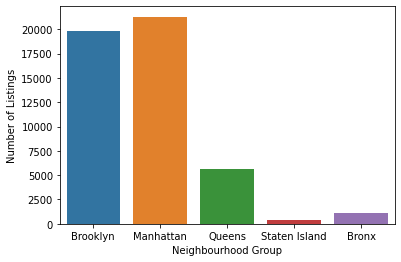

In [106]:
n_listings = [df.loc[df[neighbourhood_group] == neighbourhood].shape[0] for neighbourhood in neighbourhood_groups]
ax = sns.barplot(x=neighbourhood_groups, y=n_listings)
ax.set(xlabel="Neighbourhood Group", ylabel="Number of Listings")
plt.show()

We can also do this for individual neighbourhoods:

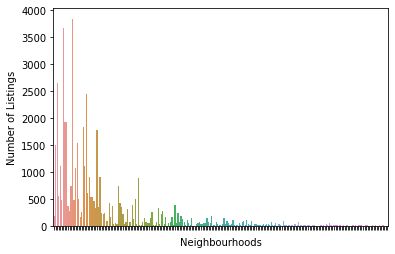

In [107]:
neighbourhoods = "neighbourhood"
u_neighbourhoods = df[neighbourhoods].unique()  # Get all unique neighbourhoods

n_listings = [df.loc[df[neighbourhoods] == neighbourhood].shape[0] for neighbourhood in u_neighbourhoods]
ax = sns.barplot(x=u_neighbourhoods, y=n_listings)
ax.set(xlabel="Neighbourhoods", ylabel="Number of Listings", xticklabels=[])
plt.show()

We can further analyze the data we have by checking to see which neighbourhoods have the most and least listings. To find the most frequent neighbourhood, we can calculate the mode of the `'neighbourhood'` column using the `mode()` function:

In [108]:
max_neighbourhood = df[neighbourhoods].mode()[0]
listings_in_max_neighbourhood = df.loc[df[neighbourhoods] == max_neighbourhood]
print("Neighbourhood with the most listings: {}".format(max_neighbourhood))
listings_in_max_neighbourhood.describe(include='all')

Neighbourhood with the most listings: Williamsburg


,id,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Z Score
count,3.846000e+03,3.846000e+03,3846,3846,3846,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000
unique,NaN,NaN,1,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Brooklyn,Williamsburg,Private room,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,3846,3846,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.744330e+07,4.437926e+07,NaN,NaN,NaN,131.993240,6.133385,21.902496,0.886204,1.486999,72.557462,0.040724
std,1.085634e+07,6.487156e+07,NaN,NaN,NaN,79.833047,22.304493,44.350854,1.333385,3.866795,111.126169,0.427214
min,6.848000e+03,2.438000e+03,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-0.665618
25%,7.895395e+06,3.961609e+06,NaN,NaN,NaN,73.000000,2.000000,1.000000,0.040000,1.000000,0.000000,-0.274969
50%,1.723593e+07,1.582021e+07,NaN,NaN,NaN,100.000000,3.000000,5.000000,0.300000,1.000000,3.000000,-0.130483
75%,2.688442e+07,4.982732e+07,NaN,NaN,NaN,175.000000,5.000000,19.000000,1.130000,1.750000,107.000000,0.270868


We've explored mean price in the different neighbourhood groups in the previous section so that'll be omitted here as the process of visualizing the mean price for each neighbourhood group can easily be extended to visualizing mean price on a neighbourhood basis.

Another factor we can visualize and analyze is the room type per neighbourhood group.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


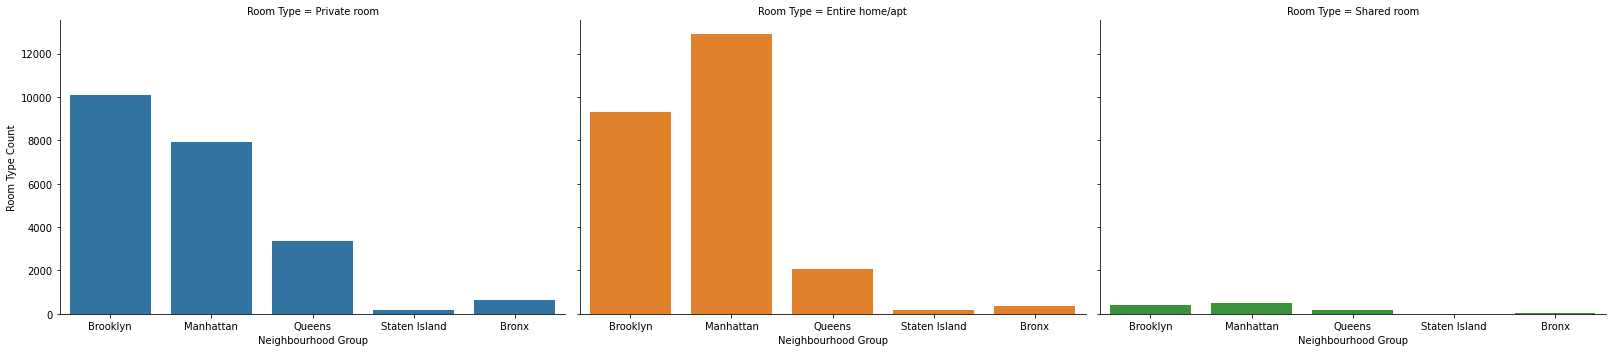

In [109]:
room_types = df['room_type'].unique()

room_type_aggr_data = [(room_type, pd.DataFrame({"Room Type Count": [df.loc[(df['neighbourhood_group'] == group) & (df['room_type'] == room_type)].shape[0] for group in neighbourhood_groups], "Neighbourhood Group": neighbourhood_groups})) for room_type in room_types]
concat_room_types = pd.concat([df.assign(Dataset=room_type) for room_type, df in room_type_aggr_data])
concat_room_types.columns.values[-1] = "Room Type"

grid = sns.FacetGrid(concat_room_types, col="Room Type", hue="Room Type", height=5.0, aspect=1.5)
grid.map(sns.barplot, "Neighbourhood Group", "Room Type Count")

Judging by the figures above, private rooms in Brooklyn are the most prevalent, while the most of home/apt and shared room listings are in Manhattan.

# **3. Host analysis and number of houses per host**

First thing we can check is the number of unique hosts:

In [110]:
unique_hosts = df['host_id'].unique()
unique_hosts.shape[0]

36927

Which is obviously smaller than the number of rows in our dataframe. Therefore, it is safe to assume that there are hosts who have several listings. We can create a dataframe and calculate the number of listings per host as per below:

In [111]:
n_listings = [df.loc[df["host_id"] == host].shape[0] for host in unique_hosts]
listings_df = pd.DataFrame({"host_id": unique_hosts, "n_listings": n_listings})
listings_df.describe()

,host_id,n_listings
count,3.692700e+04,36927.000000
mean,6.124394e+07,1.304032
std,7.490755e+07,2.769160
min,2.438000e+03,1.000000
25%,7.035356e+06,1.000000
50%,2.675473e+07,1.000000
75%,8.768542e+07,1.000000
max,2.743213e+08,327.000000


Using the dataframe description above, we can draw a couple interesting conclusions:


*   The mean number of listings per host is 1.3
*   There is a host with 327 listings

Given that the host with 327 outliers may be an outlier, we'll perform outlier filtering on this dataframe and analyze our host data again:

In [112]:
listings_df[z_score] = np.abs(stats.zscore(listings_df['n_listings']))
filtered_listings_df = listings_df[listings_df[z_score] < 2]

filtered_listings_df.describe()

,host_id,n_listings,Z Score
count,3.668300e+04,36683.000000,36683.000000
mean,6.087915e+07,1.199657,0.152988
std,7.461928e+07,0.610186,0.163005
min,2.438000e+03,1.000000,0.109794
25%,7.007072e+06,1.000000,0.109794
50%,2.650223e+07,1.000000,0.109794
75%,8.641125e+07,1.000000,0.109794
max,2.743213e+08,6.000000,1.695833


After outlier removal, it's clear that the vast majority of hosts only have a single listing and there were only approximately 250 hosts that had more than 2 listings (and were filtered as outliers).
For hosts with more than 2 listings, we have:

In [113]:
outlier_host_df = listings_df[listings_df[z_score] >= 2]
outlier_host_df.describe()

,host_id,n_listings,Z Score
count,2.440000e+02,244.000000,244.000000
mean,1.160858e+08,16.995902,5.666731
std,9.539878e+07,29.328493,10.591260
min,2.951280e+05,7.000000,2.056958
25%,2.082427e+07,8.000000,2.418083
50%,1.048703e+08,9.000000,2.779208
75%,2.133516e+08,13.000000,4.223709
max,2.733542e+08,327.000000,117.617044


It's clear that the vast minority of hosts have over 2 listings, but the aggregate data for them is *very* different than that of hosts with only one or two listings.

# **4. Comment analysis**

To check which hosts have the highest number of reviews, we have to take average reviews into account given than some hosts have more than one listing. For this, we won't filter hosts with extremely high number of listings, because it doesn't matter. Instead, we'll only calculate the average number of comments.

In [114]:
avg_review_key = "average n reviews"
listings_df[avg_review_key] = [df.loc[df['host_id'] == host]['number_of_reviews'].mean() for host in unique_hosts]
listings_df[avg_review_key].describe()

count    36927.000000
mean        22.512861
std         42.027785
min          0.000000
25%          1.000000
50%          5.000000
75%         23.000000
max        602.500000
Name: average n reviews, dtype: float64

We can also find the hosts with the most reviews and visualize our data:

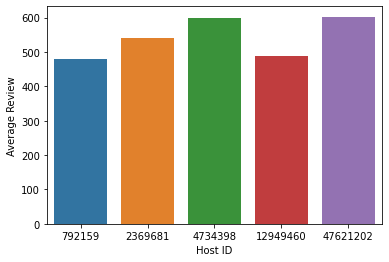

In [115]:
top_hosts = listings_df.nlargest(5, avg_review_key)
top_hosts

ax = sns.barplot(x='host_id', y=avg_review_key, data=top_hosts)
ax.set(xlabel="Host ID", ylabel="Average Review")
plt.show()

To see what factors might play a role in the number of reviews of a specific listing, we can construct a *correlation matrix* and analyze its output.

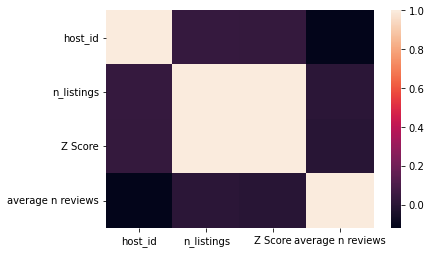

In [116]:
correlation = listings_df.corr()
sns.heatmap(correlation)

As there are no immediately obvious correlations, let's construct a correlation matrix for our entire dataframe. Since we have columns with values that aren't numbers such as `room_type` and `neighbourhood_group`, we'll need to replace those values with numbers.

*    For `room_type`, we'll replace *'Shared room'*, '*Private room'*, '*Entire home/apt*' with 0, 1, and 2 respectively
*    For `neighbourhood_group`, we'll replace each group with it's average_price order out of all the other neighbourhoods with 0 being the cheapest neighbourhood group.

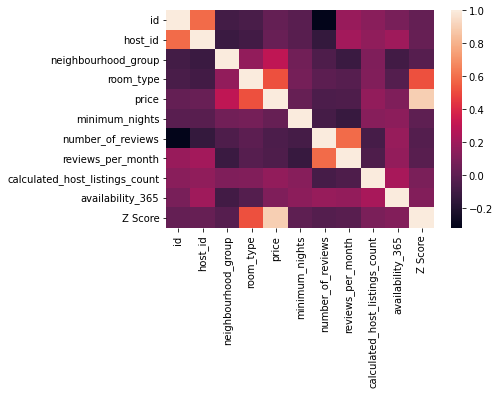

In [117]:
alt_df = df.copy()
room_types = ["Shared room", "Private room", "Entire home/apt"]
for i, room_type in enumerate(room_types):
  alt_df.loc[alt_df["room_type"] == room_type, "room_type"] = i

# We already have mean_price for each neighbourhood group so we'll just reuse that
price_per_group = sorted([x for x in zip(neighbourhood_groups, mean_prices)], key=lambda tup: tup[1])
for i, group in enumerate(price_per_group):
  alt_df.loc[alt_df["neighbourhood_group"] == group[0], "neighbourhood_group"] = i


alt_df = alt_df.astype({'room_type': 'int', "neighbourhood_group": "int"})

correlation = alt_df.corr()
sns.heatmap(correlation)

It's hard to draw any concrete conclusions, but the number of reviews seems to be dependent the most on the number of days the listing is available in a year, compared to all the other contributing factors.

# **5. Statistical hypothesis checking**

In this section we'll conduct 5 statistical hypothesis tests over 3 different categories to check and see if our data meets various assumptions.

## 1. Normality Tests

### 5.1) D’Agostino’s K^2 Test
We'll check the `price` data to see if it has a Gaussian distribution under the assumption that observations in each row are independent and identically distributed.

An option would have been to use the Shapiro-Wilk test, however, it may not been accurate for data where there are more 5000 datapoints

In [118]:
from scipy.stats import normaltest

price_column = df['price'].sample(n=5000)
stat, p = normaltest(price_column, axis=None)
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

Probably not Gaussian


Our results don't change, even after we normalize our data using min-max normalization:

In [119]:
df['normal_price'] = (df['price']-df['price'].min())/(df['price'].max()-df['price'].min())
stat, p = normaltest(df['normal_price'], axis=None)
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')
 

Probably not Gaussian


Our test has failed, meaning that our `price` column does not have a Gaussian distribution. To get a better idea of what our prices look like, we can plot it on a histogram.

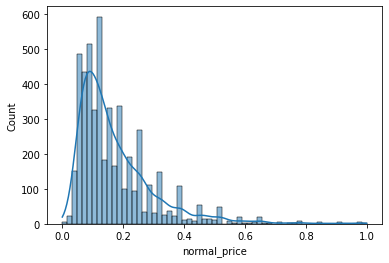

In [120]:
sample_prices = df['normal_price'].sample(n=5000)

sns.histplot(sample_prices, kde=True)

Which looks a lot closer to a chi-square distribution than a Gaussian distribution. We can check our hypothesis:

### 5.2) Chi-square test

In [121]:
from scipy.stats import chisquare

chisq, p = chisquare(sample_prices)
if p > 0.05:
	print('Probably chi-square')
else:
	print('Probably not chi-square')

Probably chi-square


Correct!

## 2. Correlation Tests

In correlation tests, we test to see if two samples have a linear relationship. In the previous section we examined the relation between number of reviews and other factors to a certain extent by creating a correlation matrix, but here we'll examine things more in depth.

We've already constructed a dataframe `alt_df` where `room_type` and `neighbourhood_group` were replaced with numerical values, so we'll use that.

### 5.3) Spearman's correlation coefficient

Here, we'll check the correlation between `room_type` and `price`. Judging by the correlation heatmap constructed in the previous section, these two are closely linked, therefore, that relationship should reflect in this test.

Another commonly used coefficient would be Pearson's correlation coefficient, however, that works under the assumption that our data is normally distribution, which we have shown that it's not.

In [122]:
from scipy.stats import spearmanr

stat, p = spearmanr(alt_df['price'], alt_df['room_type'])
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

Probably dependent


And our hypothesis was correct.

We can conduct one more correlation test to see if two categorical variables are related or independent.

### 5.4) Kendall’s Rank Correlation

Here, we'll examine relation between `price` and `neighbourhood_group`. Judging by how various values in `neighbourhood_group` were replaced with numbers, there should be a dependency between these two columns.

In [123]:
from scipy.stats import kendalltau

stat, p = kendalltau(alt_df["neighbourhood_group"], alt_df["price"])
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

Probably dependent


## 3. Nonparametric Statistical Hypothesis Tests

In nonparametric statistical hypothesis tests, we check to see if two samples are significantly different, to the point of being from different distributions.

### 5.5) Mann-Whitney U Test

In this test, we'll compare `neighbourhood_group` and `price` to check and see if the distribution of these two are equal or not.

In [124]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(alt_df["neighbourhood_group"], alt_df["price"])
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

Probably different distributions


Interestingly enough, even though there is a strong correlation between neighbourhood_group and price, it seems that these two belong to different distributions.


# **6. Prediction Model**

## 6.1. Data Preparation

In this section, we'll create a model to predict the `price` column.
To create our model, we'll first drop columns that don't play a role and might negatively skew our results, like `host id` and `id`.

We can also drop columns we have no use for anymore, such as `normal_price` and `Z score`

In [182]:
data = df.drop(columns=["id", "host_id", "Z Score", "normal_price"], axis=1)

data.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0


While in `alt_df`, we've already encoded the values of `room_type` and `neighbourhood_group` and converted them to numbers, one-hot encoding makes our training data more useful and nuanced. The columns we need to convert are:


*   `neighbourhood_group`
*   `neighbourhood`
*   `room_type`

However, since there are many neighbourhoods, and trying to encode the neighbourhoods via one-hot vectors would add too many columns, we will omit individual neighbourhoods for now. 

We can use this by [`pd.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) that converts categorical variables into dummy/indicator variables.

In [183]:
data = data.drop(columns=["neighbourhood"], axis=1)

# Encode neighbourhood_group
one_hot_groups = pd.get_dummies(df["neighbourhood_group"])
data = data.drop('neighbourhood_group', axis=1)
data = data.join(one_hot_groups)


# Encode room type
one_hot_room = pd.get_dummies(df["room_type"])
data = data.drop("room_type", axis=1)
data = data.join(one_hot_room)

data.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,149,1,9,0.21,6,365,0,1,0,0,0,0,1,0
1,225,1,45,0.38,2,355,0,0,1,0,0,1,0,0
2,150,3,0,0.00,1,365,0,0,1,0,0,0,1,0
3,89,1,270,4.64,1,194,0,1,0,0,0,1,0,0
4,80,10,9,0.10,1,0,0,0,1,0,0,1,0,0


The next step would be to split our labels and our features. We'll create two new variables, `X` and `Y`.

After that, we'll split our data in training and test sets. This is easily done using `sklearn`'s `train_test_split()` method.

In [184]:
from sklearn.model_selection import train_test_split

# Split features/labels
X = data.drop("price", axis=1)
y = data["price"]

# Split train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # 20% of data is set aside for test set

Our data is now prepared for the model and we can move onto building and training the model.


## 6.2. Training the model

Here, we will use a simple linear regression model and attempt to fit the model to our data to accurately predict listing prices. Using `sklearn`'s built-in functions, this is easy.

Our model is an ordinary least squares linear regression model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

[Model documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [151]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()  # Create the model
linear_model.fit(X_train, y_train) # Fit the model to our data

LinearRegression()

## 6.3. Testing our model

Now that our model is trained, we can now test it and see how we did using the testing data we had set aside. To evaluate how well our model did, we can use `sklearn`'s built-in metrics.

In [180]:
from sklearn import metrics

# Predict
y_pred = linear_model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 51.96390561727754
Mean Squared Error: 6432.898879594539
Root Mean Squared Error: 80.20535443219822


We can also place our predictions side-by-side with the correct values to better understand how well our model did:

In [159]:
pred_df = pd.DataFrame({"pred": y_pred, "truth": y_test})
pred_df["delta"] = abs(pred_df["pred"] - pred_df["truth"])

pred_df["delta"].describe()

count    9631.000000
mean       51.606586
std        60.071179
min         0.010949
25%        16.533255
50%        35.772811
75%        65.120211
max       598.058897
Name: delta, dtype: float64

Judging by the description above, about 50% of our predictions were less that 35 units away from the correct value, with one prediction being 598 units away from the correct value

We can learn more about which features were important by checking the model coefficients. The closer a coefficient is to 0, the more the model has learned that a specific feature is not important, and decreases its' performance on the output.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

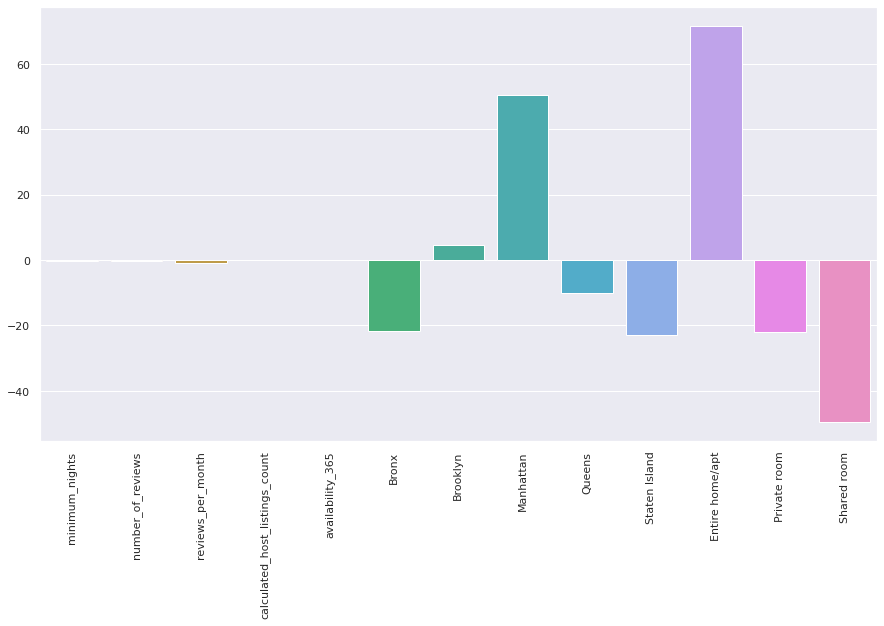

In [170]:
from matplotlib import pyplot

coefficients = linear_model.coef_
columns = list(X_train.columns)
fig, ax = pyplot.subplots(figsize=(15.0, 8.0))
sns.barplot(x=columns, y=coefficients, ax=ax)
plt.xticks(rotation=90)

Judging by the graph above, we can draw several conclusions about the effect of different variables on a listing's price.



*   The most influencial factor in the listing price would be what kind of room_type the listing was. Listings with the type Entire home/apt greatly increased the price, while Shared rooms had a very negative effect on the price
*   Neighbourhood group also played a large role, with listings in Manhattan having significantly postive effects on the price, while having a listing be in Bronx decreased the price.
*   Other factors such as minimum_nights and availabilty_365 had very little significance, if any.


We can try to remove the extra columns and see if its performance improves.



In [173]:
# Drop unimportant features
data = data.drop(columns=["minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365"], axis=1)

# Split features/labels
X = data.drop("price", axis=1)
y = data["price"]

# Split train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # 20% of data is set aside for test set

# Model creation
linear_model = LinearRegression()  
linear_model.fit(X_train, y_train) 

# Test our model
y_pred = linear_model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 51.96390561727754
Mean Squared Error: 6432.898879594539
Root Mean Squared Error: 80.20535443219822


And as you can see, there is very little difference, because during training the model has already essentially 'removed' the unimportant features from the model.

Additionally, we can also check our model's intercept:

In [174]:
linear_model.intercept_

-339991387662866.94

Another algorithm we could use to predict the price would be the [random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

As per sklearn's documentation: A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

This model uses ensemble learning for regression, which combines predictions from multiple models with the hopes of increasing accuracy. We can try fitting a model to our data before comparing it to our linear regression model.

In [186]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)


# Test our model
y_pred = random_forest.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 49.435112181792164
Mean Squared Error: 5824.404453144986
Root Mean Squared Error: 76.31778595547034


And as we can see, the random forest model has significantly better results, due to it's robustness and methodology. The only setback is that random forests are unable to extrapolate outside unseen data. However, for the purposes of this project, it suffices.